11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/50
469/469 [==============================] - 15s 27ms/step - loss: 202.8896 - val_loss: 174.0716
Epoch 2/50
469/469 [==============================] - 12s 26ms/step - loss: 171.1674 - val_loss: 169.1046
Epoch 3/50
469/469 [==============================] - 11s 23ms/step - loss: 167.5221 - val_loss: 166.4166
Epoch 4/50
469/469 [==============================] - 7s 15ms/step - loss: 165.1298 - val_loss: 164.3994
Epoch 5/50
469/469 [==============================] - 6s 14ms/step - loss: 163.2508 - val_loss: 162.7123
Epoch 6/50
469/469 [==============================] - 7s 16ms/step - loss: 161.6431 - val_loss: 161.2347
Epoch 7/50
469/469 [==============================] - 6s 13ms/step - loss: 160.3155 - val_loss: 159.8579
Epoch 8/50
469/469 [==============================] - 7s 15ms/step - loss: 159.2036 - val_loss: 158.9810
Epoch 9/50
469/469 [==============================] - 6s 13ms/step - loss: 158.2942 - val_lo

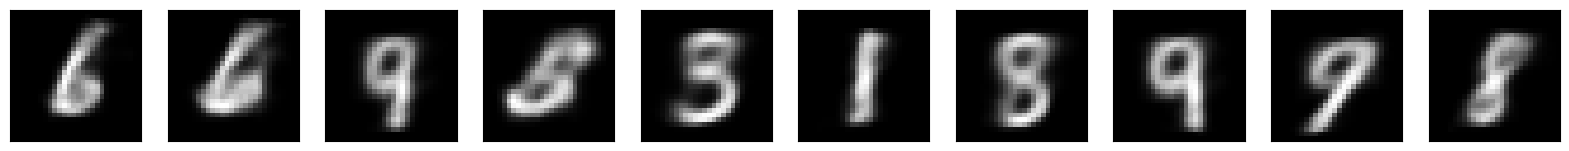

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist

# Load MNIST dataset (you can replace this with your own dataset)
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and flatten the images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define VAE architecture
original_dim = 784
latent_dim = 2

# Encoder
input_img = Input(shape=(original_dim,))
encoded = Dense(256, activation='relu')(input_img)
z_mean = Dense(latent_dim)(encoded)
z_log_var = Dense(latent_dim)(encoded)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = Input(K.int_shape(z)[1:])
decoded = Dense(256, activation='relu')(decoder_input)
decoded_output = Dense(original_dim, activation='sigmoid')(decoded)

# Define models
encoder = Model(input_img, z_mean)

decoder = Model(decoder_input, decoded_output)

# Define VAE model
vae_output = decoder(z)
vae = Model(input_img, vae_output)

# Define loss
reconstruction_loss = K.sum(K.binary_crossentropy(input_img, vae_output), axis=-1)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))

# Generate new images
z_sample = np.random.normal(size=(10, latent_dim))
generated_images = decoder.predict(z_sample)

# Display generated images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()